In [1]:
import pandas as pd
import numpy as np
import tqdm


from auxfuncs import reduce_mem_usage, code_mean, timeseries_train_test_split, plotModelResults, plotCoefficients, plotForecastResults 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def chop(x):
    return x[:-11]

In [3]:
!unzip sales_train_validation.zip

Archive:  sales_train_validation.zip
  inflating: sales_train_validation.csv  


In [5]:
!unzip sample_submission.zip

Archive:  sample_submission.zip
  inflating: sample_submission.csv   


In [1]:
sales = reduce_mem_usage(pd.read_csv('sales_train_validation.csv'))[0]

In [8]:
def prepare_sales_validation(sales):

    d_cols = [c for c in sales.columns if 'd_' in c]

    rename = {c: int(c[2:]) for c in d_cols}

    sales = sales.rename(columns=rename)

    sales.id = sales.id.apply(chop)

    return sales



In [9]:
sales = prepare_sales_validation(sales)

In [10]:
def prepare_ts(id, sales, lag_start, lag_end, rolling=True, rolling_year=True):

    '''id is a string and sales is a sales validation dataframe. Function returns
    a time series with lags for the given product id, no aggregation is made.'''   
    
    pilot = sales[sales.id==id][[col for col in sales.columns if isinstance(col, int)]].T
  
    pilot = pilot.rename(columns={list(pilot.columns)[0]:'target'})

    for i in range(lag_start, lag_end):

        pilot["lag_{}".format(i)] = pilot['target'].shift(i)
        pilot["rolling_mean_{}".format(i)] = pilot['target'].rolling(window=i).mean()
        pilot["rolling_median_{}".format(i)] = pilot['target'].rolling(window=i).median()
        
    if rolling_year:
        
        pilot["rolling_year_mean"] = pilot['target'].rolling(window=365).mean()
        pilot["rolling_year_median"] = pilot['target'].rolling(window=365).median()
             
   
    pilot = pilot.dropna()     


    return pilot 




In [11]:
!unzip sell_prices.zip

Archive:  sell_prices.zip
  inflating: sell_prices.csv         


In [2]:
sell = reduce_mem_usage(pd.read_csv('sell_prices.csv'))[0]

In [13]:
def prepare_sell(sell):


    sell['id'] = sell.item_id+'_'+sell.store_id

    return sell

In [14]:
sell = prepare_sell(sell)

In [15]:
!unzip calendar.zip 

Archive:  calendar.zip
  inflating: calendar.csv            


In [3]:
calendar = reduce_mem_usage(pd.read_csv('calendar.csv'))[0]

In [17]:
#Remove the following holidays from calendar: Xmas, NY eve, NY day, Easter, TGiving,....

def prepare_calendar(calendar):

    calendar = calendar[~(calendar.event_name_1.isin(['SuperBowl', 'StPatricksDay', 'LaborDay', 'Thanksgiving', 'Christmas', 'NewYear', 'Easter']))]
    day_col = calendar.d
    rename = {c: int(c[2:]) for c in day_col}
    calendar['d'] = calendar['d'].replace(rename)
    calendar = calendar.rename(columns={'d':'day'})
    calendar = calendar[['wm_yr_wk','wday', 'month', 'day']]
    days = pd.get_dummies(calendar.wday).drop(columns=[7])
    calendar = calendar.join(days)
    rename_days = {1:'Sat', 2:'Sun', 3:'M', 4:'T', 5: 'W', 6:'R'}
    calendar = calendar.rename(columns=rename_days)

    return calendar


In [18]:
calendar = prepare_calendar(calendar)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
def merge_pilot_sell(id, pilot, sell, calendar):
    ''' Merge pilot with sell and calendar to create full regression table.'''  
    
    sell_item = pd.merge(calendar, sell[sell.id==id], how='left', on='wm_yr_wk')
    sell_item = sell_item.dropna()
    sell_item = sell_item[['wday', 'day', 'sell_price', 'Sat', 'Sun', 'M', 'T', 'W','R']]  
    pilot['day'] = pilot.index
    pilot = pd.merge(sell_item, pilot, how='left', on='day')
    pilot['is_weekend'] = pilot.wday.isin([1,2])*1
    pilot = pilot.drop(columns=['wday'])
    pilot = pilot.dropna()
    pilot = pilot.drop(columns=['day'])

    return pilot


In [21]:
def prepareData(data, test_size, target_encoding=False):
  

    
    
    # train-test split
    y = data['target']
    X = data.drop(['target'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size)

    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'wday', "y").get, data.wday))
        data["month_average"] = list(map(code_mean(data[:test_index], 'month', "y").get, data.month))
        data["weekend_average"] = list(map(code_mean(data[:test_index], 'is_weekend', "y").get, data.month))
    
    if test_size>0:
        return X_train, X_test, y_train, y_test
    elif test_size==0:
        return X_train, y_train

In [22]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
tscv = TimeSeriesSplit(n_splits=5)
scaler = StandardScaler()
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb






In [24]:
def single_lag_forcast(model, pilot, horizon, forest=False, use_cv=False):

    '''horizon = No. of days into future to forecast '''
    
    if use_cv:

        alpha = Get_optimal_Lasso_parameters(pilot, horizon)

        model = Lasso(alpha)
           
     
    X_train, y_train = prepareData(pilot, test_size=0.0, target_encoding=False)
  
    
    X_train_scaled = scaler.fit_transform(X_train)
    model.fit(X_train_scaled, y_train)
    forecast = model.predict(scaler.transform(X_train[-horizon:]))

    return forecast
    

In [25]:
!unzip sales_train_evaluation.zip

Archive:  sales_train_evaluation.zip
  inflating: sales_train_evaluation.csv  


In [4]:
#eval = reduce_mem_usage(pd.read_csv('sales_train_evaluation.csv'))[0]



In [159]:
def prepare_sales_eval(eval):

    eval = eval.drop(columns=['item_id','dept_id','cat_id','store_id','state_id'])
    eval.id = eval.id.apply(chop)
    d_cols = [c for c in eval.columns if 'd_' in c]

    rename = {c: int(c[2:]) for c in d_cols}

    eval = eval.rename(columns=rename)
    

    return eval  

In [160]:
eval = prepare_sales_eval(eval)

In [30]:
def show_me_forecast_graph(forecast, id, horizon):
   
    '''Returns a plot of forecast and actual data.'''
        
    actual = (eval[eval.id==id].T[-horizon:]).reset_index(drop=True)

    return plotForecastResults(forecast, actual) 

In [31]:
def MSE(forecast, horizon, id):    

    return mse((eval[eval.id==id].T[-horizon:]).reset_index(drop=True).to_numpy(), forecast)

In [32]:
def MAE(forecast, horizon, id):    

    return mae((eval[eval.id==id].T[-horizon:]).reset_index(drop=True).to_numpy(), forecast)

In [33]:
def produce_forecast(model, id, lag_start, lag_end, eval=False, Err=False, plot=True, horizon=28, coeff=False):
    

    if eval:
        pilot = prepare_ts(id, eval, lag_start, lag_end, rolling=True)
    else:
        pilot = prepare_ts(id, sales, lag_start, lag_end, rolling=True)           
    
    pilot = merge_pilot_sell(id, pilot, sell, calendar)  

    #Get_optimal_Lasso_parameters(pilot, horizon) used implicitly in single lag forecast.
    forecast = single_lag_forcast(model, pilot, horizon)
    

    if plot:
        return show_me_forecast_graph(forecast, id, horizon)
    
    elif coeff:
      return plotCoefficients(model, pilot.drop(columns=['target']))     

    elif Err:
        return pd.DataFrame({'id': [id], 'mse_score': [MSE(forecast, horizon, id)], 'mae_score':[MAE(forecast, horizon, id)]})   

     




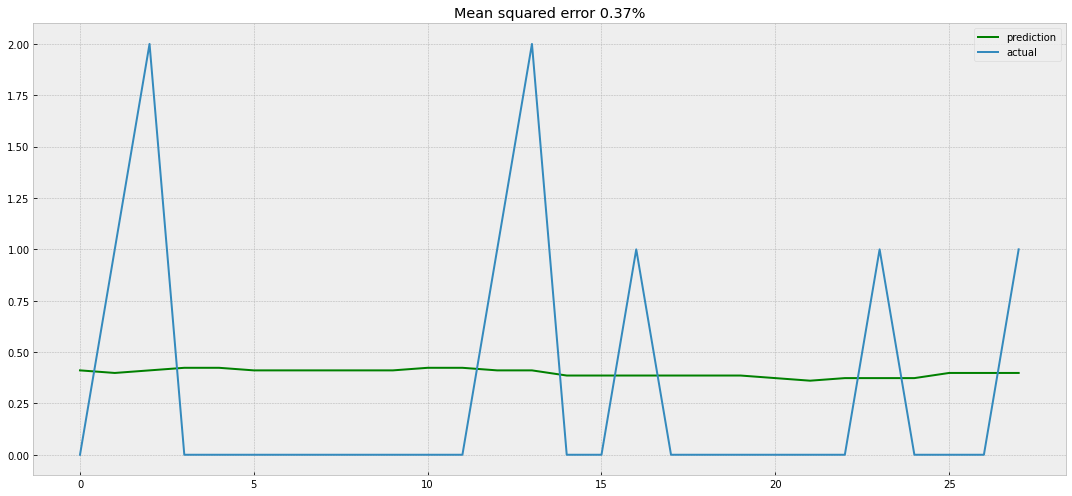

In [163]:
produce_forecast(Lasso(0.1), 'HOBBIES_1_004_WI_1', 28, 38, plot=True, coeff=True)


In [ ]:
#mean of last 28 days as const predictor:

scores_n = []  
for id in tqdm(sales.id):  
    naive_28_forecast = ((eval[eval.id==id].T[-56:-28]).reset_index(drop=True)).mean()  
    score = MSE(np.repeat(naive_28_forecast,28), 28, id)
    scores_n.append(score)
    



100%|██████████| 30490/30490 [03:59<00:00, 127.14it/s]


In [ ]:
np.asarray(scores_n[0:26000]).mean()

4.246668023940345

In [ ]:
#MSE Score from using avg of last 28 days as const predictor for the next 28: 5.03
#MSE Score from using prev 28 days to predict the next 28 by shiting: 8.00
#MSE Score from my model to pred. next 28 days: 5.24



In [5]:
from tqdm import tqdm


scores = []  
scores_n = []
for id in tqdm(sales.id.sample(n=9000)):  
    score = produce_forecast(Lasso(0.1), id, 28, 38, Err=True, plot=False)
    scores.append(score)
    naive_28_forecast = ((eval[eval.id==id].T[-56:-28]).reset_index(drop=True)).mean()  
    score_n_mse = MSE(np.repeat(naive_28_forecast,28), 28, id)
    score_n_mae = MAE(np.repeat(naive_28_forecast,28), 28, id)
    scores_n.append(pd.DataFrame({'id': [id], 'N_mse_score': [score_n_mse], 'N_mae_score':[score_n_mae]}))
    
scores_df = pd.concat(scores)
scores_n_df = pd.concat(scores_n)
final_df = pd.merge(scores_df, scores_n_df, how='left', on='id')

  

"from tqdm import tqdm\n\n\nscores = []  \nscores_n = []\nfor id in tqdm(sales.id.sample(n=9000)):  \n    score = produce_forecast(Lasso(0.1), id, 28, 38, Err=True, plot=False)\n    scores.append(score)\n    naive_28_forecast = ((eval[eval.id==id].T[-56:-28]).reset_index(drop=True)).mean()  \n    score_n_mse = MSE(np.repeat(naive_28_forecast,28), 28, id)\n    score_n_mae = MAE(np.repeat(naive_28_forecast,28), 28, id)\n    scores_n.append(pd.DataFrame({'id': [id], 'N_mse_score': [score_n_mse], 'N_mae_score':[score_n_mae]}))\n    \nscores_df = pd.concat(scores)\nscores_n_df = pd.concat(scores_n)\nfinal_df = pd.merge(scores_df, scores_n_df, how='left', on='id')"

In [ ]:
#results: 

#28-32, alpha=0.1, mse wins 515 times and mae wins 512 times

#28-32, alpha=1.0, lose, lose

#28-38, alpha = 0.1, mse wins 563 times and mae wins 502 times BEST

In [ ]:
#how many times better mse:

len(final_df[final_df.mse_score<final_df.N_mse_score])

4972

In [ ]:
#how many times better mae:

len(final_df[final_df.mae_score<final_df.N_mae_score])

4691

In [6]:

#Finally train the model on the full evaluation set and begin prep for final submission:

from tqdm import tqdm


dic = {}
for id in tqdm(eval.id):

    pilot = prepare_ts(id, eval, 28, 38, rolling=True)           
    pilot = merge_pilot_sell(id, pilot, sell, calendar)
    forecast = single_lag_forcast(Lasso(0.1), pilot, 28)
    dic[id] = forecast

df = pd.DataFrame.from_dict(dic).T

df = df.reset_index()


df = df.rename(columns={'index': 'id'})

df.id = df.id+'_evaluation'

rename = {day:'F'+str(day+1) for day in range(0,28)}

df = df.rename(columns=rename)

    

'"\n#Finally train the model on the full evaluation set and begin prep for final submission:\n\nfrom tqdm import tqdm\n\n\ndic = {}\nfor id in tqdm(eval.id):\n\n    pilot = prepare_ts(id, eval, 28, 38, rolling=True)           \n    pilot = merge_pilot_sell(id, pilot, sell, calendar)\n    forecast = single_lag_forcast(Lasso(0.1), pilot, 28)\n    dic[id] = forecast\n\ndf = pd.DataFrame.from_dict(dic).T\n\ndf = df.reset_index()\n\n\ndf = df.rename(columns={\'index\': \'id\'})\n\ndf.id = df.id+\'_evaluation\'\n\nrename = {day:\'F\'+str(day+1) for day in range(0,28)}\n\ndf = df.rename(columns=rename)'

In [206]:
df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_evaluation,0.832548,0.829364,0.829237,0.877866,0.877866,0.988167,1.054774,1.048191,0.963543,0.933367,0.887670,0.878245,0.942722,0.887885,0.926747,0.975122,0.999436,0.978306,1.002746,1.070787,1.027656,1.002620,0.978432,0.954118,0.960486,1.024130,1.039979,1.006272
1,HOBBIES_1_002_CA_1_evaluation,0.212135,0.218301,0.218301,0.218301,0.218301,0.218301,0.218301,0.218301,0.218301,0.228622,0.228622,0.228622,0.228622,0.228622,0.228622,0.228622,0.228622,0.228622,0.228622,0.238943,0.259584,0.269905,0.280226,0.274060,0.269905,0.269905,0.269905,0.269905
2,HOBBIES_1_003_CA_1_evaluation,0.501298,0.501298,0.522532,0.543766,0.543766,0.586233,0.586233,0.586233,0.586233,0.586233,0.565000,0.607467,0.628701,0.692403,0.692403,0.692403,0.692403,0.649935,0.628701,0.607467,0.607467,0.586233,0.565000,0.543766,0.586233,0.628701,0.607467,0.607467
3,HOBBIES_1_004_CA_1_evaluation,1.510639,1.179565,1.227706,1.424952,1.582900,2.770526,3.269138,1.698137,1.678001,1.623931,1.545644,1.554781,2.890199,3.345990,1.609626,1.404397,1.460306,1.494961,1.492172,2.634171,3.128048,1.630312,1.442644,1.248901,1.347029,1.435429,2.728409,3.120280
4,HOBBIES_1_005_CA_1_evaluation,1.124765,1.124765,1.124274,1.160845,1.124274,1.398411,1.434982,1.124274,1.124765,1.147101,1.147101,1.214108,1.577097,1.636495,1.310569,1.340514,1.348123,1.385186,1.355241,1.673558,1.636495,1.325787,1.325787,1.318178,1.288233,1.302960,1.621277,1.561388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,0.255451,0.255451,0.255451,0.303214,0.350976,0.350976,0.350976,0.350976,0.398739,0.398739,0.398739,0.422620,0.446501,0.470383,0.461053,0.422620,0.446501,0.446501,0.461053,0.422620,0.494264,0.494264,0.518145,0.542026,0.537362,0.518145,0.542026,0.561243
30486,FOODS_3_824_WI_3_evaluation,0.300394,0.321920,0.343446,0.364972,0.364972,0.343682,0.322392,0.279813,0.301339,0.301339,0.344155,0.343918,0.322156,0.300866,0.279576,0.258286,0.258286,0.258050,0.257814,0.257578,0.257342,0.257342,0.257342,0.257342,0.278868,0.278868,0.279104,0.279104
30487,FOODS_3_825_WI_3_evaluation,0.814239,0.806810,0.830400,0.850022,0.821188,0.865905,0.866145,0.868129,0.853991,0.847042,0.842836,0.840852,0.824450,0.815517,0.770560,0.790701,0.803564,0.826195,0.822226,0.775525,0.754914,0.743947,0.729089,0.752679,0.741762,0.734534,0.719636,0.755660
30488,FOODS_3_826_WI_3_evaluation,0.853568,0.938337,0.938337,0.966593,1.023106,1.051362,1.023106,1.051362,1.023106,1.023106,1.051362,1.023106,1.051362,1.023106,1.051362,1.023106,1.079618,1.023106,1.051362,1.079618,1.079618,1.192643,1.362181,1.333925,1.362181,1.305669,1.305669,1.220900


In [7]:
eval.id = eval.id+'_validation'

valid_part = eval[['id']+list(range(1914,1942))]

rename = {day:'F'+str(day-1913) for day in range(1914,1942)}

valid_part = valid_part.rename(columns=rename)

"eval.id = eval.id+'_validation'\n\nvalid_part = eval[['id']+list(range(1914,1942))]\n\nrename = {day:'F'+str(day-1913) for day in range(1914,1942)}\n\nvalid_part = valid_part.rename(columns=rename)"

In [220]:
final_non_baseline_sub0 = pd.concat([valid_part, df])

final_non_baseline_sub0

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,2.000000,2.000000,1.000000,0.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,1.000000
1,HOBBIES_1_002_CA_1_validation,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,HOBBIES_1_003_CA_1_validation,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,3.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,1.000000
3,HOBBIES_1_004_CA_1_validation,0.000000,0.000000,1.000000,2.000000,4.000000,1.000000,6.000000,4.000000,0.000000,0.000000,0.000000,2.000000,2.000000,4.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,4.000000,0.000000,1.000000,3.000000,0.000000,2.000000,6.000000
4,HOBBIES_1_005_CA_1_validation,1.000000,0.000000,2.000000,3.000000,1.000000,0.000000,3.000000,2.000000,3.000000,1.000000,1.000000,3.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,0.255451,0.255451,0.255451,0.303214,0.350976,0.350976,0.350976,0.350976,0.398739,0.398739,0.398739,0.422620,0.446501,0.470383,0.461053,0.422620,0.446501,0.446501,0.461053,0.422620,0.494264,0.494264,0.518145,0.542026,0.537362,0.518145,0.542026,0.561243
30486,FOODS_3_824_WI_3_evaluation,0.300394,0.321920,0.343446,0.364972,0.364972,0.343682,0.322392,0.279813,0.301339,0.301339,0.344155,0.343918,0.322156,0.300866,0.279576,0.258286,0.258286,0.258050,0.257814,0.257578,0.257342,0.257342,0.257342,0.257342,0.278868,0.278868,0.279104,0.279104
30487,FOODS_3_825_WI_3_evaluation,0.814239,0.806810,0.830400,0.850022,0.821188,0.865905,0.866145,0.868129,0.853991,0.847042,0.842836,0.840852,0.824450,0.815517,0.770560,0.790701,0.803564,0.826195,0.822226,0.775525,0.754914,0.743947,0.729089,0.752679,0.741762,0.734534,0.719636,0.755660
30488,FOODS_3_826_WI_3_evaluation,0.853568,0.938337,0.938337,0.966593,1.023106,1.051362,1.023106,1.051362,1.023106,1.023106,1.051362,1.023106,1.051362,1.023106,1.051362,1.023106,1.079618,1.023106,1.051362,1.079618,1.079618,1.192643,1.362181,1.333925,1.362181,1.305669,1.305669,1.220900


In [221]:
final_non_baseline_sub0.to_csv('final_real_sub0.csv', index=False)